**Importing the necessary packages**

In [38]:
from vowpalwabbit import pyvw
import random
import numpy as np
import matplotlib.pyplot as plt

**Defining the reward values**

In [39]:
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

**Introducing varying noise in the reward:**\
Noise is the stochastic choice of USER_LIKED_ARTICLE with a small probability of getting the opposite reward instead of choosing it deterministically. Hence with probability of epsilon the opposite reward is chosen and probability of (1-epsilon) the expected reward.\
\
**Why does noise make sense in our context?**\
Noise makes sense in the this context because even if the user likes sports in the morning generally, sometimes he might dislike it, so this noise helps to model that behaviour.

In [40]:
#With probability of (1-eps) USER_LIKED_ARTICLE chosen
def positivereward(p,eps):
    if p<eps:
        return USER_DISLIKED_ARTICLE
    else:
        return USER_LIKED_ARTICLE
    
#With probability of (1-eps) USER_DISLIKED_ARTICLE chosen    
def negativereward(p,eps):
    if p<eps:
        return USER_LIKED_ARTICLE
    else:
        return USER_DISLIKED_ARTICLE

**To incorporate mutiple changes in the reward distribution over time, multiple cost functions are defined with changing preferences**\
For example: Tom might be keen on watching politics in the morning if there is an election taking place however would be keen on watching sports in the morning if the Olympic Games are being held.

In [41]:
def get_cost_elections(context,action,eps): # Election being held hence politics preferred by both
    if context['user'] == "Tom":
        p=np.random.random()
        if context['time_of_day'] == "morning" and action == 'politics':
            return positivereward(p,eps)
        elif context['time_of_day'] == "afternoon" and action == 'music':
            return positivereward(p,eps)
        else:
            return negativereward(p,eps)
    elif context['user'] == "Anna":
        p=np.random.random()
        if context['time_of_day'] == "morning" and action == 'sports':
            return positivereward(p,eps)
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return positivereward(p,eps)
        else:
            return negativereward(p,eps)
            
def get_cost_olympics(context,action, eps): # Olympics being held hence sports preferred by both
    if context['user'] == "Tom":
        p=np.random.random()
        if context['time_of_day'] == "morning" and action == 'politics':
            return positivereward(p,eps)
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return positivereward(p,eps)
        else:
            return negativereward(p,eps)
    elif context['user'] == "Anna":
        p=np.random.random()
        if context['time_of_day'] == "morning" and action == 'sports':
            return positivereward(p,eps)
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return positivereward(p,eps)
        else:
            return negativereward(p,eps)
        
def get_cost_grammy(context,action, eps): # Grammy Awards being held hence music preferred by both
    if context['user'] == "Tom":
        p=np.random.random()
        if context['time_of_day'] == "morning" and action == 'music':
            return positivereward(p,eps)
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return positivereward(p,eps)
        else:
            return negativereward(p,eps)
    elif context['user'] == "Anna":
        p=np.random.random()
        if context['time_of_day'] == "morning" and action == 'music':
            return positivereward(p,eps)
        elif context['time_of_day'] == "afternoon" and action == 'food':
            return positivereward(p,eps)
        else:
            return negativereward(p,eps)
        
def get_cost_world_health_day(context,action, eps): # World Health Day hence health preferred by both
    if context['user'] == "Tom":
        p=np.random.random()
        if context['time_of_day'] == "morning" and action == 'music':
            return positivereward(p,eps)
        elif context['time_of_day'] == "afternoon" and action == 'health':
            return positivereward(p,eps)
        else:
            return negativereward(p,eps)
    elif context['user'] == "Anna":
        p=np.random.random()
        if context['time_of_day'] == "morning" and action == 'health':
            return positivereward(p,eps)
        elif context['time_of_day'] == "afternoon" and action == 'food':
            return positivereward(p,eps)
        else:
            return negativereward(p,eps)
        
def get_cost_budget(context,action, eps): # Budget being disclosed hence finance preferred by both
    if context['user'] == "Tom":
        p=np.random.random()
        if context['time_of_day'] == "morning" and action == 'camping':
            return positivereward(p,eps)
        elif context['time_of_day'] == "afternoon" and action == 'finance':
            return positivereward(p,eps)
        else:
            return negativereward(p,eps)
    elif context['user'] == "Anna":
        p=np.random.random()
        if context['time_of_day'] == "morning" and action == 'finance':
            return positivereward(p,eps)
        elif context['time_of_day'] == "afternoon" and action == 'finance':
            return positivereward(p,eps)
        else:
            return negativereward(p,eps)


**Function to modify (context, action, cost, probability) to VW friendly format**


In [42]:
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(context["user"], context["time_of_day"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    return example_string[:-1]

**Function to sample the pmf to get the action after calculating the pmf values for the list of actions**

In [43]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

**Function to return the action and probability of choosing it**

In [44]:
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

**Defining users, actions, times of day and functions to randomly make a user and time of day choice**

In [45]:
users = ['Tom', 'Anna']
times_of_day = ['morning', 'afternoon']
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]
def choose_user(users):
    return random.choice(users)

def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)

**Function for plotting and incorporating the non-stationarity with a changing reward distribution over time**

In [46]:
def plot_ctr(num_iterations, ctr):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])

def run_simulation_multiple_cost_functions(vw, num_iterations, users, times_of_day, actions, cost_functions, epsilon, do_learn = True):
    cost_sum = 0.
    ctr = []
    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
            user = choose_user(users)
            time_of_day = choose_time_of_day(times_of_day)
            context = {'user': user, 'time_of_day': time_of_day}
            action, prob = get_action(vw, context, actions)
            cost = cost_function(context, action, epsilon)
            cost_sum += cost
            if do_learn:
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                vw.learn(vw_format)
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations

    return ctr

**Defining the cost function and epsilon parameter for the noise. Further to increase the stochasticity the different preference based cost functions are chosen randomly**

In [47]:
num_iterations_per_cost_func = 5000
epsilon=0.15
cost_functions = [get_cost_olympics, get_cost_world_health_day, get_cost_grammy, get_cost_budget,get_cost_elections]
cost_functions= random.choices(cost_functions,k=4)
total_iterations = num_iterations_per_cost_func * len(cost_functions)

**Using the cb_explore_adf contextual bandit algorithm and exploring with the epsilon-greedy algorithm with epsilon value = 0.2 and plotting ctr vs num_iterations**

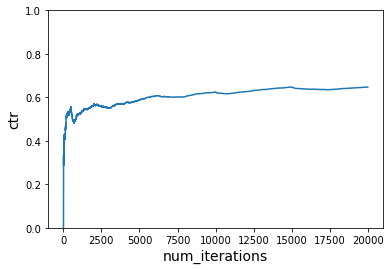

In [48]:
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")
ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, epsilon)
plot_ctr(total_iterations, ctr)

**The above case without learning**

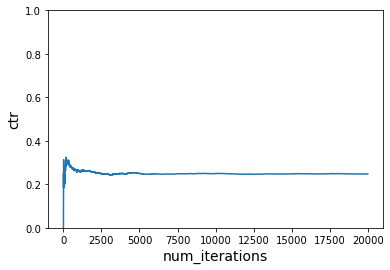

In [49]:
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")
ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, epsilon, do_learn=False)
plot_ctr(total_iterations, ctr)

**Using the cb_explore_adf contextual bandit algorithm and exploring with the explore-first algorithm with tau value = 2 and plotting ctr vs num_iterations**

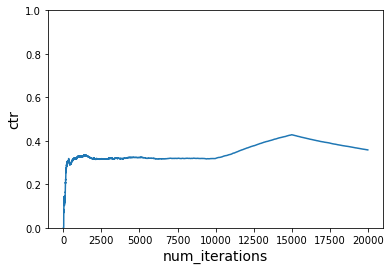

In [50]:
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --first 2")
ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, epsilon)
plot_ctr(total_iterations, ctr)

**The above case without learning**

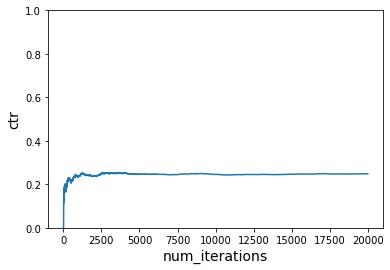

In [51]:
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --first 2")
ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, epsilon, do_learn=False)
plot_ctr(total_iterations, ctr)

**Using the cb_explore_adf contextual bandit algorithm and exploring with the bagging explorer algorithm with m = 5 and plotting ctr vs num_iterations**

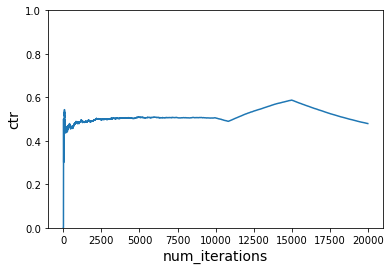

In [52]:
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --bag 5")
ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, epsilon)
plot_ctr(total_iterations, ctr)

**The above case without learning**

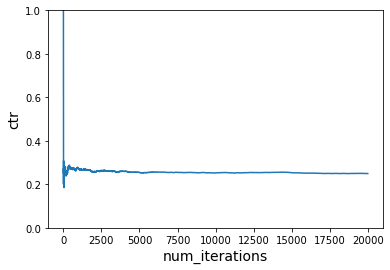

In [53]:
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --bag 5")
ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, epsilon, do_learn=False)
plot_ctr(total_iterations, ctr)

**Using the cb_explore_adf contextual bandit algorithm and exploring with the online cover algorithm with m = 3 and plotting ctr vs num_iterations**

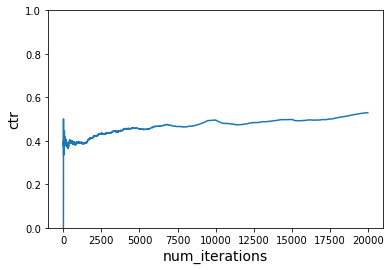

In [54]:
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --cover 3")
ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, epsilon)
plot_ctr(total_iterations, ctr)

**The above case without learning**

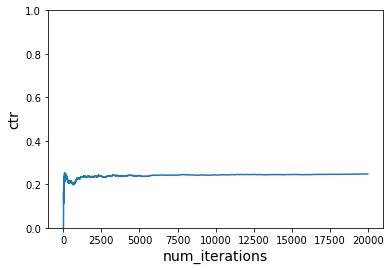

In [55]:
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --cover 3")
ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, epsilon, do_learn=False)
plot_ctr(total_iterations, ctr)

**Using the cb_explore_adf contextual bandit algorithm and exploring with the softmax explorer algorithm with lambda = 10 and plotting ctr vs num_iterations**

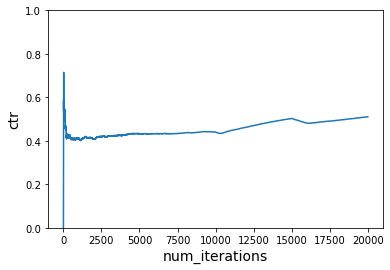

In [56]:
vw = pyvw.vw("--cb_explore_adf --quiet --softmax --lambda 10")
ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, epsilon)
plot_ctr(total_iterations, ctr)